# **READER - Assignment 11**

# Types of classifiers

**Binary versus Multiclass Binary classifiers** For binary the model assigns to two options, usually -1 and +1. Generally we are interested in predicting the postive class correctly. For multiclass, there are more than two possible labels. 

**Deterministic versus Probabilistic** Discrete classifiers produce a discrete label to each instance, probabilistic classifiers assign a continuous score between 0 and 1 to indicate likelihood, with the probability of all samples summing to 1. 
 
**Linear versus Nonlinear** A linear classifier uses a linear separating hyperplane to discriminate instances from different classes whereas a nonlinear classifier enables the construction of more complex, nonlinear decision surfaces. 

# Briefly...
In this reader and the exercises we focus on Random Forests and Neural Networks in particular. This weeks portion of the book and lecture, however, cover many more. These parts are still (as) relevant to the course. Please refer to sections 6.1, 6.3, 6.7, 6.8 and 6.10 and make sure you undestand all of them to be well prepared for the exam! Specifically make sure to understand how the following classifiers work, and what purpose they serve: k-Nearest-Neighbours, all of the Ensemble methods (not just Random Forest)

# Random Forest

## Ensemble methods
Ensemble methods combine the predictions of several models to produce a single, prediction.

The main idea is that several weak or unstable models, when combined, can create a strong model. Ensemble methods often work better than individual models because they reduce variance, reduce overfitting, and improve generalization.

## Bagging
Bagging is the combination of two words: bootstrap and aggregation, which describe exactly what it does. **Bootstrap** sampling is a technique to create many new training sets, by sampling with replacement from the original. A bootstrap training set has the same size as the original, but (likely) contains duplicates and ommisions. Using this bootstrap sampling we thus create several new traiing sets, we then train a model on each of these. **Aggregation** finally combines the predictions of all of these models, Ff classification we simply take a majority vote of the predicated labels.

## The Random Forest algorithm
Random Forests are an extension of bagging that add an additional source of randomness. The algorithm learns from the data by building many decision trees, each trained on a different bootstrap sample.

* Step 1: Generate the collection of bootstrap samples: like bagging, bootstrap sample with replacement. 
* Step 2: Learn a full decision tree on each sample: For every bootstrap dataset, grow a full, unpruned tree. 
    * But, not just normally! At each split, the algorithm randomly selects a subset of attributes of size $n$. Then, among only those selected attributes, it chooses the best possible split (Like a normal decision tree). Thus, the best split is chosen only within this subset, not among all attributes. This extra randomness reduces the similarity between trees, helping the ensemble perform better.
* Step 3: Combine the predictions of all trees: For classification: each tree votes for a class, and the final prediction is the majority vote.

The key parameter controlling a Random Forest is how many features the tree is allowed to look at when choosing a split. ($n$ Step 2)

### Example
Below we look at an example of these methods, compared to default Decision Trees:

**Decision Tree:** A single `DecisionTreeClassifier` is trained on all 200 features in the dataset. Given that 50 of these features are redundant and 20% of the labels are noisy, the tree is prone to overfitting, likely capturing irrelevant patterns from the noise and redundant features. This leads to poor generalization and reduced test accuracy.

**Bagging:** The `BaggingClassifier` trains 30 individual decision trees on random subsets of the training data. While this helps reduce overfitting by averaging over multiple trees, each tree still uses the full set of features. As a result, bagging doesn't completely address the problem of high-dimensionality or overfitting to noisy or redundant features. However, it generally performs better than a single decision tree because of the aggregation of multiple models.

**Random Forest:** The `RandomForestClassifier` improves on bagging by introducing random feature selection. For each tree in the forest, only a random subset of features is considered at each split (`max_features='sqrt'`), which reduces the correlation between trees and forces each tree to focus on different combinations of features. This helps avoid overfitting to redundant features and noise in the dataset, leading to better generalization.

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Create a dataset with many features (balanced for fairness)
X, y = make_classification(n_samples=1000, n_features=200, n_informative=10,
                           n_redundant=50, n_repeated=0, n_classes=4,
                           flip_y=0.2, 
                           class_sep=.75, random_state=0) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Models
tree = DecisionTreeClassifier(random_state=0)
bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=30, random_state=0)
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=0)

# Train
tree.fit(X_train, y_train)
bag.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Evaluate
for name, m in {"Decision Tree": tree, "Bagging": bag, "Random Forest": rf}.items():
    pred = m.predict(X_test)
    print(f"{name}: test accuracy = {accuracy_score(y_test, pred):.3f}")

Decision Tree: test accuracy = 0.333
Bagging: test accuracy = 0.467
Random Forest: test accuracy = 0.520


**In the plot below we see the following:**
The Decision Tree model has an overly complex decision boundary, leading to overfitting. The Bagging model improves on this by averaging multiple trees, leading to a smoother but still relatively complex boundary.  The Random Forest model provides the best generalization, producing the most stable decision boundary. This is due to its feature randomization process. 

We also show some examples of the trees in the Random Forest model.

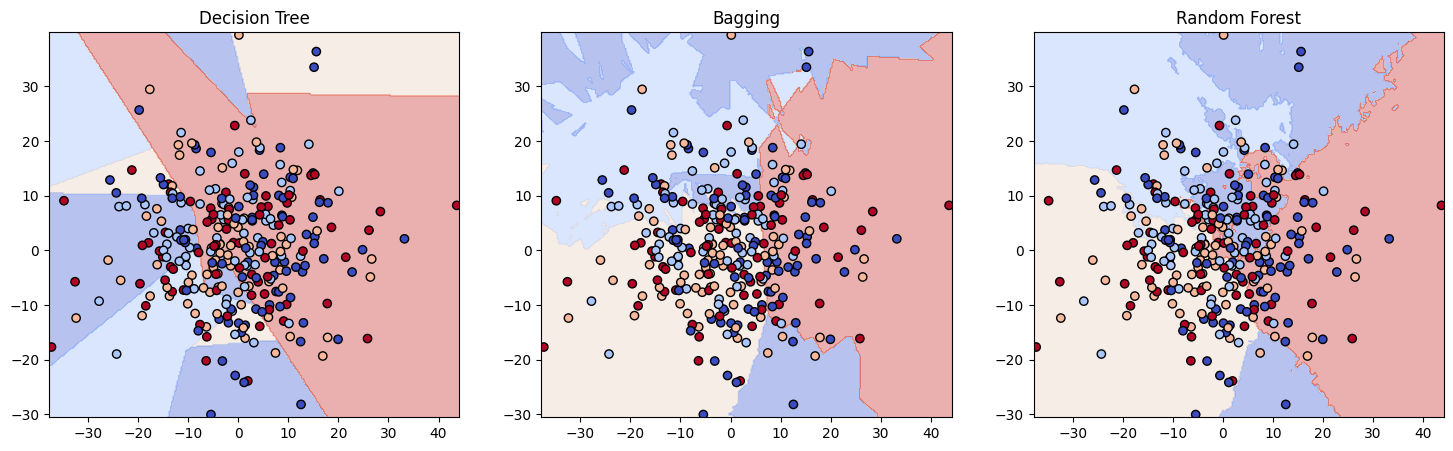

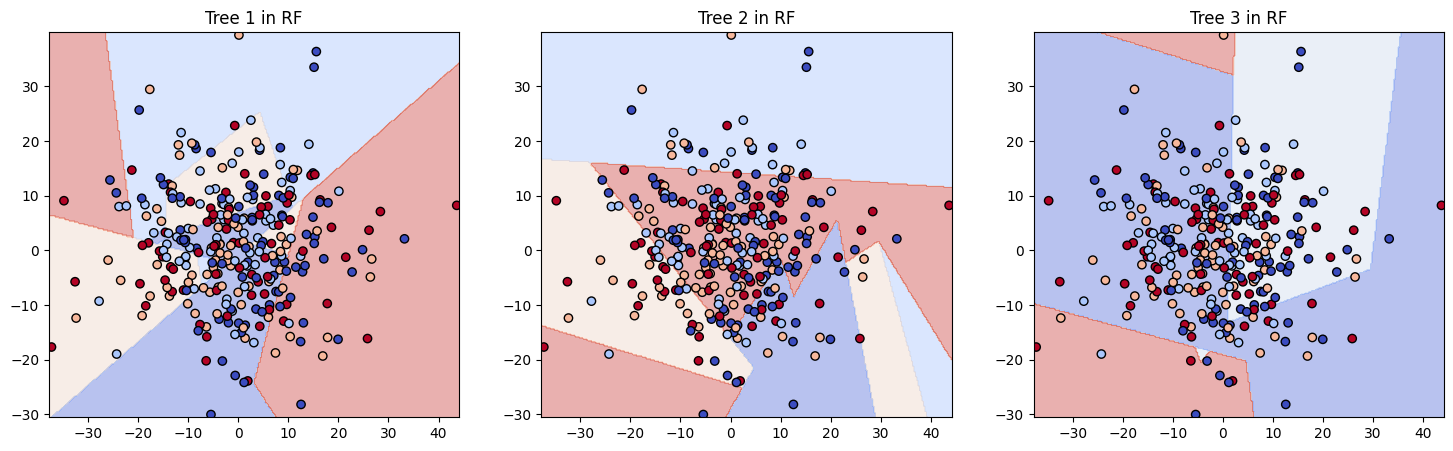

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

def plot_decision_boundary_pca(clf, pca, X_2d, y, ax, title):
    # Create grid in PCA 2D space
    x_min, x_max = X_2d[:,0].min() - .5, X_2d[:,0].max() + .5
    y_min, y_max = X_2d[:,1].min() - .5, X_2d[:,1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    # Map grid back to original 6D space
    grid_2d = np.c_[xx.ravel(), yy.ravel()]
    grid_6d = pca.inverse_transform(grid_2d)
    
    # Predict using the original model
    Z = clf.predict(grid_6d).reshape(xx.shape)
    
    # Plotting decision boundary
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="coolwarm")
    ax.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap="coolwarm", edgecolor="k")
    ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(18,5))
for clf, title, ax in zip([tree, bag, rf], 
                          ["Decision Tree", "Bagging", "Random Forest"],
                          axes):
    plot_decision_boundary_pca(clf, pca, X_test_2d, y_test, ax, title)
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18,5))
for i, ax in zip(range(3), axes):
    plot_decision_boundary_pca(rf.estimators_[i], pca, X_test_2d, y_test, ax, f"Tree {i+1} in RF")
plt.show()

# Neural Networks

## What is a Neural Network?

A Neural Network (NN) is a computational model inspired by the way biological neural networks (like the brain) process information. It consists of layers of interconnected nodes, called neurons. Each neuron receives inputs, processes them through an activation function, and produces an output. The connections between neurons have associated weights, which are adjusted during training to minimize the error in the network's predictions.

### Basic Components of a Neural Network
- **Input Layer:** The layer that receives the input data.
- **Hidden Layers:** Intermediate layers that transform the input into something useful for the final output.
- **Output Layer:** The layer that produces the final prediction or classification result.
- **Weights:** Parameters that connect neurons and are adjusted during training to improve the network's performance.
- **Bias/Threshold:** A constant value added to the input to help shift the activation function.
- **Activation Function:** A function applied to the input of a neuron to introduce non-linearity.

### Training a neural network
Training a neural network involves adjusting the weights of the model to minimize a loss function. This process is guided by an optimization algorithm called gradient descent, and the core method used to update the weights is called backpropagation.

1. **Loss Function**:
   - The loss function measures the difference between the predicted output and the actual target values.
   - The goal of training is to **minimize** this loss, i.e., make the network’s predictions as close to the actual values as possible.
   - Common examples of loss functions:
     - **Mean Squared Error (MSE)** for regression tasks. ($\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$)
     - **Cross-Entropy Loss** for classification tasks.

2. **Gradient Descent**:
   - Covered in week 8!
   - **Gradient descent** is an optimization algorithm used to minimize the loss function.
   - The idea is to update the model’s weights in the direction that reduces the loss.
   - The weights are updated iteratively by calculating the **gradient** (or derivative) of the loss with respect to the weights.

3. **Backpropagation**:
   - **Backpropagation** is the method used to compute the gradients of the loss function with respect to each weight in the network.
   - It involves two key steps:
     - **Forward Pass**: Input data is passed through the network to compute the output.
     - **Backward Pass**: The error (difference between predicted and actual values) is propagated backward through the network to calculate the gradients for each weight.
   - The gradients tell us how much and in which direction to adjust the weights to minimize the loss.

4. **Updating the Weights**:
   - After computing the gradients, the weights are updated using the **gradient descent rule**:
     - Weights are adjusted by subtracting a small portion of the gradient (scaled by a factor called the **learning rate**).
   - This process is repeated over multiple iterations (epochs), gradually improving the model's performance.

### Training Process:

1. **Initialization**:
   - Randomly initialize the weights and biases of the network.

2. **Forward Pass**:
   - Pass the input data through the network to obtain the predicted output.
   - Calculate the loss using the predicted output and the actual target.

3. **Backward Pass (Backpropagation)**:
   - Compute the gradient of the loss with respect to each weight.
   - Use the chain rule to propagate the error backward through the layers.

4. **Weight Update**:
   - Update the weights using the gradients and the learning rate.

5. **Iteration**:
   - Repeat the forward pass, backward pass, and weight updates for multiple epochs until the loss converges to a minimum.


### Example
Below you see a very simple example. We train 2 neural networks: a single layer network, and a network with hidden layers. We train the models on a dataset with 4 datapoints, forming the xor problem. This means there is no way to draw a linear line to seperate the two classes. To train, we use gradient descent to update our weights based on the gradient of our loss.

A single-layer network (also called a single-layer perceptron) only has the input layer and the output layer, with no hidden layers in between. This means that the network can only learn linear relationships between the input features and the output. The mutlilayer network can learn non-linear problems because it acts as a composite of linear layers with non-linear activation functions. This enables the model to learn more complex decision boundaries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    """Activation function: maps input to range (0, 1)"""
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """Derivative of sigmoid for backpropagation"""
    return x * (1 - x)

def train_network(X, y, hidden_size=None, epochs=10000, lr=0.1):
    np.random.seed(42)
    
    if hidden_size:  # Two-layer network with hidden layer
        # ============================================================
        # 1. INITIALIZATION
        # ============================================================
        # Initialize weights with small random values
        w1 = np.random.rand(2, hidden_size) - 0.5  # Input to hidden weights
        w2 = np.random.rand(hidden_size, 1) - 0.5  # Hidden to output weights
        
        # Initialize biases to zero
        b1 = np.zeros((1, hidden_size))  # Hidden layer bias
        b2 = np.zeros((1, 1))             # Output layer bias

        # ============================================================
        # 5. ITERATION: Training loop
        # ============================================================
        for epoch in range(epochs):
            
            # ========================================================
            # 2. FORWARD PASS
            # ========================================================
            # Compute hidden layer activations
            z1 = X @ w1 + b1                    # Linear combination
            hidden = sigmoid(z1)                 # Apply activation
            
            # Compute output layer activations
            z2 = hidden @ w2 + b2               # Linear combination
            output = sigmoid(z2)                 # Apply activation
            
            # ========================================================
            # 3. BACKWARD PASS (Backpropagation)
            # ========================================================
            # Compute error at output layer
            ## Derivative of MSE
            error_output = (y - output)
            
            # Gradient at output layer (chain rule: dL/dw2 = dL/doutput * doutput/dz2 * dz2/dw2)
            d_output = error_output * sigmoid_derivative(output)
            
            # Gradient at hidden layer (propagate error backwards)
            error_hidden = d_output @ w2.T
            d_hidden = error_hidden * sigmoid_derivative(hidden)
            
            # ========================================================
            # 4. WEIGHT UPDATE
            # ========================================================
            # Update weights and biases using gradient descent
            # w = w + learning_rate * gradient
            w2 += hidden.T @ d_output * lr      # Update hidden → output weights
            b2 += np.sum(d_output, axis=0, keepdims=True) * lr  # Update output bias
            
            w1 += X.T @ d_hidden * lr           # Update input → hidden weights
            b1 += np.sum(d_hidden, axis=0, keepdims=True) * lr  # Update hidden bias
            
    else:  # Single-layer perceptron (no hidden layer)
        # ============================================================
        # 1. INITIALIZATION
        # ============================================================
        w = np.random.rand(2, 1) - 0.5  # Input to output weights
        b = np.zeros((1, 1))             # Output bias
        
        # ============================================================
        # 5. ITERATION: Training loop
        # ============================================================
        for epoch in range(epochs):
            
            # ========================================================
            # 2. FORWARD PASS
            # ========================================================
            z = X @ w + b                       # Linear combination
            output = sigmoid(z)                  # Apply activation
            
            # Calculate loss
            
            # ========================================================
            # 3. BACKWARD PASS (Backpropagation)
            # ========================================================
            ## Derivative of MSE
            error = (y - output)
            d_output = error * sigmoid_derivative(output)
            
            # ========================================================
            # 4. WEIGHT UPDATE
            # ========================================================
            w += X.T @ d_output * lr            # Update weights
            b += np.sum(d_output, axis=0, keepdims=True) * lr  # Update bias
        
    return output

# ================================================================
# XOR PROBLEM
# ================================================================

# Train both models
slp_out = train_network(X, y, hidden_size=None, epochs=10000, lr=0.1)
nn_out = train_network(X, y, hidden_size=2, epochs=10000, lr=0.5)

# Display final predictions
print("="*60)
print("FINAL PREDICTIONS")
print("="*60)
print(f"\nSingle-Layer Perceptron predictions:")
print(slp_out.flatten())
print(f"\nTwo-Layer Network predictions:")
print(nn_out.flatten())

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, output, title in zip(axes, [slp_out, nn_out], 
                               ["Single-Layer Perceptron", "Two-Layer Network"]):
    scatter = ax.scatter(X[:, 0], X[:, 1], c=output.flatten(), 
                        cmap='coolwarm', s=100, edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.grid(True)
    fig.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

### Loss functions

The **loss function** measures the difference between the predicted output and the actual target value. The goal is to minimize this loss during training to improve the network’s performance. 

#### Common Loss Functions:
1. **Squared Error Loss**  
   This is typically used for regression tasks where the difference between predicted and actual values is squared to penalize large errors more heavily.  
   Formula:
   $$
   L = \sum (y_i - \hat{y_i})^2
   $$
   Where $y_i$ is the actual value and $ \hat{y_i} $ is the predicted value.

2. **Cross-Entropy Loss**  
   This loss function is commonly used for classification tasks, especially when the output is probabilistic (i.e., softmax activation). It compares the predicted probability distribution to the actual class label.
   Formula:
   $$
   L = -\sum y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i})
   $$
   The key difference between cross-entropy and squared error is that cross-entropy's gradient is not linear; it scales in such a way that even for predictions that are near the correct value, the gradient remains significant enough for weight updates. 

   *Note:* Cross-Entropy loss is equivalent to Maximum Likelihood Estimation for multi-class classification. This is ideal, as this means that by maximizing the likelihood, the model adjusts its parameters to make the observed data (the true class labels) as likely as possible. MSE (Squared Error) doesn't account for the probabilistic nature of the classification problem. In classification, the model predicts a probability distribution over classes, and the goal is to maximize the likelihood of the correct class, not to minimize the squared distance between the predicted and actual class labels. Thus when we are using MSE rather than cross-entropy loss for classification, we are optimizing something else!

#### Key Points:
- Loss functions drive how the network adjusts its weights during training.
- Cross-entropy is preferred for classification tasks due to its more robust gradient behavior compared to squared error.

In [ ]:
import numpy as np

# Function to calculate MSE loss and gradient
def mse_loss_and_grad(y_true, y_pred):
    loss = (y_true - y_pred) ** 2
    grad = -2 * (y_true - y_pred)  
    return loss, grad

# Function to calculate Cross-Entropy loss and gradient
def ce_loss_and_grad(y_true, y_pred):
    loss = -y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)
    grad = -y_true / y_pred + (1 - y_true) / (1 - y_pred) 
    return loss, grad

y_true = 1
predictions = [0.01, 0.1, 0.5, 0.9, 0.99]

# Compute and display losses and gradients for both MSE and Cross-Entropy
for y_pred in predictions:
    mse_l, mse_grad = mse_loss_and_grad(y_true, y_pred)
    ce_l, ce_grad = ce_loss_and_grad(y_true, y_pred)
    print(f"\nPredicted: {y_pred:.2f}")
    print(f"MSE Loss: {mse_l:.4f}, MSE Gradient: {mse_grad:.4f}")
    print(f"Cross-Entropy Loss: {ce_l:.4f}, Cross-Entropy Gradient: {ce_grad:.4f}")


### Activation Functions
**Activation functions** introduce non-linearity into the neural network, enabling it to learn complex relationships within the data.

### Common Activation Functions:
1. **Sigmoid:**  
   The sigmoid function squashes input values to a range between 0 and 1, often used for binary classification tasks. However, it suffers from the **vanishing gradient problem**, where gradients become very small for extreme values, slowing learning.

   Formula:
   $$
   \sigma(x) = \frac{1}{1 + e^{-x}}
   $$

2. **ReLU (Rectified Linear Unit):**  
   ReLU is the most widely used activation function because it allows for faster learning by avoiding the vanishing gradient problem. It outputs zero for negative input and passes positive values unchanged.

   Formula:
   $$
   \text{ReLU}(x) = \max(0, x)
   $$

3. **Leaky ReLU:**  
   Leaky ReLU is a variation of ReLU that allows a small, non-zero gradient when the input is less than zero, which helps avoid the **dying ReLU problem** where neurons stop learning entirely.

   Formula:
   $$
   \text{Leaky ReLU}(x) = \max(\alpha x, x) \quad \text{where} \ \alpha \text{ is a small constant}
   $$
4. Many, many more
 
### Key Considerations:
- **ReLU** is the most commonly used due to its simplicity and efficiency.

### Example
Below we visualize the three activation functions we just outlined. We also show their gradients. For the sigmoid function we now indeed see that the gradients for very high and very low values drop to near 0. Furthermore we see that the gradient for ReLU is indeed 0 for any value <=0. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Activation functions and derivatives
activations = {
    'Sigmoid': (
        lambda x: 1 / (1 + np.exp(-x)),
        lambda x: (s := 1 / (1 + np.exp(-x))) * (1 - s)
    ),
    'ReLU': (
        lambda x: np.maximum(0, x),
        lambda x: np.where(x > 0, 1, 0)
    ),
    'Leaky ReLU': (
        lambda x: np.maximum(0.05 * x, x),
        lambda x: np.where(x > 0, 1, 0.01)
    )
}

# Generate data
x = np.linspace(-10, 10, 100)
colors = ['b', 'g', 'r']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for (name, (func, deriv)), color in zip(activations.items(), colors):
    axes[0].plot(x, func(x), label=name, color=color)
    axes[1].plot(x, deriv(x), label=f"{name} Gradient", color=color, linestyle='--')

for ax, title, ylabel in zip(axes, 
                               ["Activation Functions", "Activation Function Gradients"],
                               ["Output", "Gradient"]):
    ax.set_title(title)
    ax.set_xlabel("Input")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### Regularization and/or Initialization
We don't delve deeper into this in this weeks homework, but have a brief look at the relevant sections of the book and the slides!

## Applying Neural Networks to an actual dataset
In this week exercises, exercise 3 shows you some basics of PyTorch and how you can use it to build a neural network to approximate the sine wave (If you have not completed this exercise yet, we strongly recommend doing so first!). Though, this example was a bit lame as we saw the data generation process, so we could also have run gradient descent on a proposed function $f(x) = a \sin(bx)$ to find the parameters $a$ and $b$. The point, of course, is that we normally don't exactly know what the data generation process looks like. Let's look into a more realistic example.

We consider a dataset from Kaggle: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?resource=download&select=diabetes_binary_5050split_health_indicators_BRFSS2015.csv.

It is a medical dataset regarding diabetes diagnoses. Let's start exploring it.

In [1]:
import pandas as pd
import kagglehub
import glob
import os

# Download dataset (cached automatically by kagglehub)
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")

# Find and load CSV
csv_file = glob.glob(os.path.join(path, '**', '*.csv'), recursive=True)[0]
dataset = pd.read_csv(csv_file)
n_features = len(dataset.columns) - 1
print(f"Loaded dataset: {dataset.shape}")
print(f"Features: {n_features}")
print(dataset.columns)

100%|██████████| 6.03M/6.03M [00:01<00:00, 6.03MB/s]

Extracting files...


Loaded dataset: (253680, 22)
Features: 21
Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')


In [15]:
## Optional TODO
## We provide bare minimum implementations of RF and NN on this problem, often it's smart to explore your dataset before doing so...

Above, we see all the columns that this dataset has to offer. For a description of each of the columns, check the 'About this file' on Kaggle.
We want to compare how well a neural network performs in comparison to a simpler and less compute-heavy model, like Random Forest. To this end, we will provide a cross-validated implementation of a Random Forest model:

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

X, y = np.array(dataset.drop(columns=['Diabetes_012'])), np.array(dataset['Diabetes_012'])
model = RandomForestClassifier()
# 10-fold cross validation:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
print(f'Generalization accuracy: {scores.mean()}')
print(f'Generalization accuracy standard deviation: {scores.std()}')

Generalization accuracy: 0.8412567013560391
Generalization accuracy standard deviation: 0.0013622358467582734


Below, we define our Neural Network, we call it CustomNet! If you don't know how to implement this yet, we once again refer you to exercise 3 of week 11. To continue, for a starting point, you could literally copy-paste your functions from there to here :)

In [ ]:
class CustomNet(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        # TODO: come up with an architecture. (Layer (sizes), activation functions, number of layers, etc.)
        raise NotImplementedError
    
    def forward(self, x):
        # TODO: program the way a prediction is computed.
        raise NotImplementedError

You have seen the theory and some small manual implementations on the training of a (Deep) Neural Network above. In practice, people hardly compute and provide the gradients of their functions, and manually perform back-propegation, instead this is all abstracted away behind a (several) level(s) of abstraction.

Below, we provide a more standard training set-up. Some things might not be quite clear, so we very briefly cover some interesting things that are going on:
- `loss.backward()` --> this is used to automatically perform the back-propegation, including gradients, weight updates, the whole shablam.
- `torch.optim.Adam()` --> this is a bit out of scope, but if you use NNs for your project, it might be relevant. In the explanation above, the learning rate is static; We define lr=x for some value x and it stays this way. This can be far from ideal, and Adam fixes a lot of these issues.
- `device` --> this again is a bit out of scope, but Neural Networks were not made to be ran on CPUs... The device calls try to ensure that where possible, computation is distributed over a GPU, and only brought back to the CPU where needed!

In [ ]:
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'

n_folds = 10
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
train_epochs = 1000

average_accuracy = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = torch.tensor(X[train_idx], dtype=torch.float32, device=device), torch.tensor(X[val_idx], dtype=torch.float32, device=device)
    y_train, y_test = torch.tensor(y[train_idx], dtype=torch.float32, device=device), y[val_idx]

    model = CustomNet(n_features=n_features).to(device=device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(train_epochs):
        optimizer.zero_grad()
        pred = model(X_train)
        loss = loss_fn(pred.squeeze(1), y_train)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        logits = model(X_test)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()

    average_accuracy.append(accuracy_score(y_test, preds.cpu()))

average_accuracy = np.array(average_accuracy)
print(f'Generalization accuracy: {average_accuracy.mean()}')
print(f'Generalization accuracy standard deviation: {average_accuracy.std()}')

Looking at the cell below, why do you think it is a good idea that we used the stratified version of k-folds, rather than regular k-fold validation for this particular dataest.

In [27]:
np.unique(y, return_counts=True)

(array([0., 1., 2.]), array([213703,   4631,  35346], dtype=int64))

### A brief recap of K-folds
In this weeks exercise 4 you will implement a setup, similar to the one above, yourself. We ask you to compare the performance of two classifiers on a non-trivial dataset. There are many things to consider, to make sure you do this correctly! While it's nice of course to see a big number for your accuracy, it is far more important that this number is *right*! 

If we simply fit a model to a large set of training data, and later evaluate it on this same training data, it will likely achieve ~100% accuracy (given that the model is able to create a representation of the entire training data, and we don't prevent overfitting in some other way). But is this interesting? Sure, it can be, if we have a problem that is so simple that we know that our training data is 100% representative of our testing data, and this won't change over time... If those assumptions hold we end up with a good classifier. But this is generally not the case, not even remotely...

Good practice is normally to initially create a train-test split (lets say 80-20). We do all training of the model (including hyperparameter tuning!) on only this training set. Later, we evaluate the performance of the model on the test set. The downside of this is that you lose a portion of your training data, as it will now have to be used for testing only! Similarly, we only have a small portion of the data to test on (in the example we just gave, 20%). This means the model might miss information during training, and it might end up with a test-set missing the most interesting/difficult cases. 

K-fold cross-validation addresses this by splitting the model into $k$ parts, we then use $k-1$ parts as training data, and the remaining part for evaluation of the resulting model, we call this the validation-set. We then rotate the validation-set $k$ times and take the accuracy of our model to be the average accuracy over all runs. This provides a better estimate of our model's performance, because instead of relying on one random split of the data, we now average over several random splits. Each data-point is in a validation-set exactly once, so the accuracy is still comparable. Another neat part of K-fold cross validation is that it allows us to express the variance in performance over different splits. If our test-data is similar to our training data, this means that we are able to quantify how certain we are about our computed accuracy!

A last note has to be made about hyper-parameter tuning. While K-fold cross-validation is great, and addreses several limitations of a standard train-test split, we need to be carefull about how we use it! If we fit the hyperparamters of our model directly in this cross-validation loop, we are still biasing our results to the training data! How could that be?... Well, by picking the hyperparameters based on the training data during cross-validation, our hyperparameters will be selected on the entire training data! There are several solutions to this: you can make a train-test split, do cross-validation to optimize the hyperparameters on the training portion, and then evaluate on the unseen test-data. Another option for this is Nested Cross-Validation.